In [1]:
import pandas as pd 
import scanpy as sc

In [2]:
adata = sc.read_h5ad('/Volumes/Castelo_Branco/christoffer/human_ms_xenium/data/lerma_martin/sn/sn_atlas.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 103794 × 32115
    obs: 'patient_id', 'sample_id', 'condition', 'lesion_type', 'age', 'sex', 'rin', 'pmi_hrs', 'duration_y', 'ms_class', 'cause_death', 'batch_sn', 'celltype', 'subtype'
    var: 'highly_variable', 'highly_variable_nbatches'
    obsm: 'X_pca', 'X_umap'

In [7]:
human_genes = [
    "HIF1A",     # Hypoxia inducible factor 1 alpha
    "HK2",       # Hexokinase 2
    "LDHA",      # Lactate dehydrogenase A
    "LDHB",      # Lactate dehydrogenase B
    "SLC16A1",   # Monocarboxylate transporter 1 (MCT1)
    "SLC16A3",   # Monocarboxylate transporter 4 (MCT4)

        "PDK1",      # Pyruvate dehydrogenase kinase 1
    "PFKL",      # Phosphofructokinase, liver type
   
    "MFN1",      # Mitofusin 1
    "MFN2",      # Mitofusin 2
    "OPA1",      # OPA1 mitochondrial dynamin like GTPase

    "PKM",       # Pyruvate kinase M1/2
    "PPARGC1A",  # PGC-1α, transcriptional coactivator
    "SIRT2",     # Sirtuin 2

]

In [15]:
adata.X.toarray().max()

5384.0

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


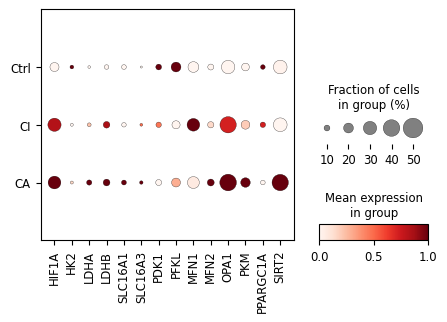

In [11]:

sc.pl.dotplot(
    adata,
    var_names=human_genes,
    groupby="lesion_type",
    standard_scale="var",
    #dot_max=0.5,
    #dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
    figsize=(5, 3),
    categories_order=['Ctrl', 'CI', 'CA'],
    #title=cell
)


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


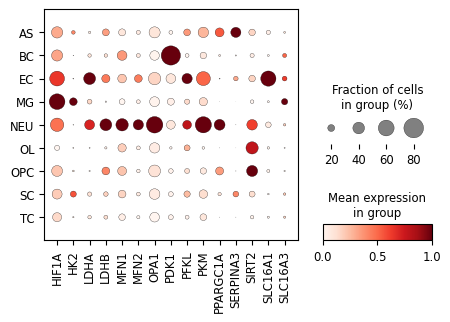

In [37]:

sc.pl.dotplot(
    adata,
    var_names=human_genes,
    groupby="celltype",
    standard_scale="var",
    #dot_max=0.5,
    #dot_min=0.05,
    color_map="Reds",
    dendrogram=False,
    figsize=(5, 3),
   # categories_order=['Ctrl', 'CI', 'CA'],
    #title=cell
)


In [16]:
# ============================================
# Dot plot across TIMEPOINTS (single-cell)
# mean (color) + % expressing (size)
# ============================================
import numpy as np, pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple

# -------- helpers --------
def _to_dense(X): return X.toarray() if sp.issparse(X) else np.asarray(X)

def _get_expr_matrix(adata, layer=None):
    X = adata.layers[layer] if (layer is not None and layer in adata.layers) else adata.X
    return _to_dense(X)

def _ensure_genes_present(adata, genes):
    pres = [g for g in genes if g in adata.var_names]
    miss = [g for g in genes if g not in adata.var_*names]
    if miss: print(f"[warn] skipping {len(miss)} missing genes:", miss[:20], "..." if len(miss)>20 else "")
    return pres

# -------- summaries (per timepoint) --------
def summarize_by_time(
    adata, genes, celltype,
    time_col="timepoint",
    ct_col="cell_type",
    layer=None,
    detect_threshold=0.0,
    time_order: Optional[List[str]] = None
) -> pd.DataFrame:
    """Return tidy table with columns: cell_type, time, gene, mean, pct_expressing, n_cells."""
    genes = _ensure_genes_present(adata, genes)
    if not genes: return pd.DataFrame()

    mask = adata.obs[ct_col].astype(str).eq(celltype) & adata.obs[time_col].notna()
    sub = adata[mask, genes]
    if sub.n_obs == 0:
        print(f"[warn] no cells for {celltype}")
        return pd.DataFrame()

    X = _get_expr_matrix(sub, layer=layer)
    df = pd.DataFrame(X, index=sub.obs_names, columns=genes)
    df["time"] = sub.obs[time_col].astype(str).values

    if time_order is None:
        # keep alphanumeric order
        time_order = sorted(df["time"].unique(), key=lambda s: (len(s), s))

    rows = []
    for t in time_order:
        dt = df[df["time"] == t]
        if dt.empty: continue
        for g in genes:
            vals = dt[g].astype(float).values
            rows.append({
                "cell_type": celltype,
                "time": t,
                "gene": g,
                "mean": float(vals.mean()),
                "pct_expressing": float((vals > detect_threshold).mean()),
                "n_cells": int(len(vals))
            })
    out = pd.DataFrame(rows)
    if out.empty: return out
    out["time"] = pd.Categorical(out["time"], categories=time_order, ordered=True)
    return out.sort_values(["gene","time"])

def compute_zscores_vs_baseline(df: pd.DataFrame, baseline_time: Optional[str] = None) -> pd.DataFrame:
    """Add z-scores per gene across time; if baseline_time given, add z_vs_baseline anchored there."""
    if df.empty: return df.copy()
    out = df.copy()

    # variance across time per gene
    sd_by_gene = out.groupby(["gene"])["mean"].std(ddof=1).replace(0, np.nan)
    mean_by_gene = out.groupby(["gene"])["mean"].mean()

    out = out.join(sd_by_gene.rename("sd_gene"), on="gene")
    out = out.join(mean_by_gene.rename("mean_gene"), on="gene")

    out["z_within_gene"] = ((out["mean"] - out["mean_gene"]) / out["sd_gene"]).replace([np.inf,-np.inf], np.nan).fillna(0.0)

    if baseline_time is not None:
        base = (out.loc[out["time"].astype(str)==str(baseline_time), ["gene","mean"]]
                  .drop_duplicates("gene").rename(columns={"mean":"mean_baseline"}).set_index("gene"))
        out = out.join(base, on="gene")
        out["z_vs_baseline"] = ((out["mean"] - out["mean_baseline"]) / out["sd_gene"])\
                                 .replace([np.inf,-np.inf], np.nan).fillna(0.0)
    return out

# -------- pretty dotplot --------
def compute_log2fc_vs_baseline(
    df: pd.DataFrame,
    baseline_time: str = "Control",
    min_mean: float = 1e-6
) -> pd.DataFrame:
    """
    Compute log2 fold-change of mean expression vs baseline_time.
    
    Expects df with columns: gene, time, mean.
    Adds: log2fc_vs_baseline
    """
    if df.empty:
        return df.copy()

    out = df.copy()

    # baseline mean per gene
    ctrl_means = (
        out.loc[out["time"].astype(str) == str(baseline_time), ["gene", "mean"]]
        .drop_duplicates("gene")
        .set_index("gene")["mean"]
    )

    # join baseline to each row
    out = out.join(ctrl_means.rename("mean_baseline"), on="gene")

    # compute log2FC = log2((mean+eps)/(ctrl+eps))
    eps = min_mean
    out["log2fc_vs_baseline"] = np.log2((out["mean"] + eps) / (out["mean_baseline"] + eps))

    return out
def plot_dotplot_time(
    df: pd.DataFrame,
    title: str = "Dotplot across time",
    color_mode: str = "log1p_mean",    # add new mode below
    cmap: Optional[str] = None,
    size_range: Tuple[int,int] = (20, 300),
    sort_genes: Optional[str] = "mean",   # allow "log2fc" too
    sort_genes_time: Optional[str] = None,
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
):
    if df.empty:
        print("[warn] nothing to plot"); return

    plot_df = df.copy()

    # --- COLOR SOURCE ---
    if color_mode == "log1p_mean":
        plot_df["color_val"] = np.log1p(plot_df["mean"]); cmap = cmap or "rocket_r"; cbar_label="log1p(mean)"
    elif color_mode == "mean":
        plot_df["color_val"] = plot_df["mean"]; cmap = cmap or "rocket_r"; cbar_label="mean"
    elif color_mode == "z_within_gene":
        assert "z_within_gene" in plot_df.columns, "run compute_zscores_vs_baseline first"
        plot_df["color_val"] = plot_df["z_within_gene"]; cmap = cmap or "coolwarm"; cbar_label="z (within gene)"
    elif color_mode == "z_vs_baseline":
        assert "z_vs_baseline" in plot_df.columns, "run compute_zscores_vs_baseline(..., baseline_time=...) first"
        plot_df["color_val"] = plot_df["z_vs_baseline"]; cmap = cmap or "coolwarm"; cbar_label="z vs baseline"
        if vmin is None or vmax is None:
            m = np.nanmax(np.abs(plot_df["color_val"].values)); vmin, vmax = -m, m
    elif color_mode == "log2fc_vs_baseline":
        assert "log2fc_vs_baseline" in plot_df.columns, "run compute_log2fc_vs_baseline(...) first"
        plot_df["color_val"] = plot_df["log2fc_vs_baseline"]; cmap = cmap or "coolwarm"; cbar_label="log2FC vs baseline"
        if vmin is None or vmax is None:
            m = np.nanmax(np.abs(plot_df["color_val"].values)); vmin, vmax = -m, m
    else:
        raise ValueError("bad color_mode")

    # --- GENE SORTING ---
    if sort_genes in {"mean","pct","z","log2fc"}:
        metric = {
            "mean": "mean",
            "pct": "pct_expressing",
            "z": "color_val",           # when using z-modes
            "log2fc": "log2fc_vs_baseline"
        }[sort_genes]
        if sort_genes_time is None:
            order = plot_df.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
        else:
            sub = plot_df.loc[plot_df["time"].astype(str) == str(sort_genes_time)]
            if sub.empty:
                order = plot_df.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
            else:
                order = sub.groupby("gene")[metric].mean().sort_values(ascending=False).index.tolist()
        plot_df["gene"] = pd.Categorical(plot_df["gene"], categories=order, ordered=True)
    elif sort_genes == "name":
        plot_df["gene"] = pd.Categorical(plot_df["gene"], categories=sorted(plot_df["gene"].unique()), ordered=True)

    # (rest of your plotting code unchanged) ...
    plot_df["pct_plot"] = plot_df["pct_expressing"] * 100.0
    fig_w = max(3, 0.9 * plot_df["time"].nunique())
    fig_h = 0.25 * plot_df["gene"].nunique() + 2.5
    plt.figure(figsize=(fig_w + 1.5, fig_h))
    ax = sns.scatterplot(
        data=plot_df, x="time", y="gene",
        size="pct_plot", sizes=size_range,
        hue="color_val", palette=cmap,
        edgecolor="0.25", linewidth=0.3, alpha=0.95,
        zorder=2, clip_on=False
    )
    plt.margins(x=0.2, y=0.05)
    ax.invert_yaxis(); ax.set_xlabel("Timepoint"); ax.set_ylabel(""); ax.set_title(title, weight="bold")

    norm = plt.Normalize(vmin if vmin is not None else plot_df["color_val"].min(),
                         vmax if vmax is not None else plot_df["color_val"].max())
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette(cmap, as_cmap=True), norm=norm); sm.set_array([])
    cbar = ax.figure.colorbar(sm, ax=ax, pad=0.02, fraction=0.03, aspect=20); cbar.set_label(cbar_label)

    if ax.get_legend(): ax.get_legend().remove()
    def area_to_ms(a): return (a/np.pi)**0.5*2.0
    levels = (10, 50, 90)
    areas = np.interp(levels, [0, 100], list(size_range))
    handles = [plt.Line2D([0],[0], marker='o', linestyle='', markerfacecolor='none',
                          markeredgecolor='0.4', markersize=area_to_ms(a)) for a in areas]
    ax.legend(handles, [f"{p}%" for p in levels], title="% expressing",
              frameon=False, loc="upper left", bbox_to_anchor=(1.02, 1.0),
              fontsize=9, title_fontsize=10)
    ax.grid(True, axis="x", color="0.92", lw=0.7); plt.xticks(rotation=35, ha="right")
    for lab in ax.get_yticklabels(): lab.set_fontstyle("italic")
    plt.tight_layout(); plt.show()

In [17]:
def _ensure_genes_present(adata, genes):
    pres = [g for g in genes if g in adata.var_names]
    miss = [g for g in genes if g not in adata.var_names]
    if miss:
        print(f"[warn] skipping {len(miss)} missing genes: {miss[:20]}" + (" ..." if len(miss) > 20 else ""))
    return pres

In [18]:
adata.obs.celltype.unique()

['NEU', 'OPC', 'OL', 'AS', 'EC', 'MG', 'TC', 'SC', 'BC']
Categories (9, object): ['AS', 'BC', 'EC', 'MG', ..., 'OL', 'OPC', 'SC', 'TC']

In [21]:
adata.obs.lesion_type

CO37-CATCCGTGTGTATTGC      Ctrl
CO37-TCGCAGGGTCCAACGC      Ctrl
CO37-CTCCAACCACCAGTTA      Ctrl
CO37-CAGGGCTCAACTCCAA      Ctrl
CO37-TAACCAGAGCATGGGT      Ctrl
                           ... 
MS549T-CATACCCAGGACTGGT      CI
MS549T-AGATAGATCGAACACT      CI
MS549T-CTGGTCTGTCGTCATA      CI
MS549T-GTGGCGTTCTCTCTAA      CI
MS549T-CTCAATTGTACAAGCG      CI
Name: lesion_type, Length: 103794, dtype: category
Categories (3, object): ['CA', 'CI', 'Ctrl']

Saved ../data/zscore_results/AS_zscore_LermaMartin.csv


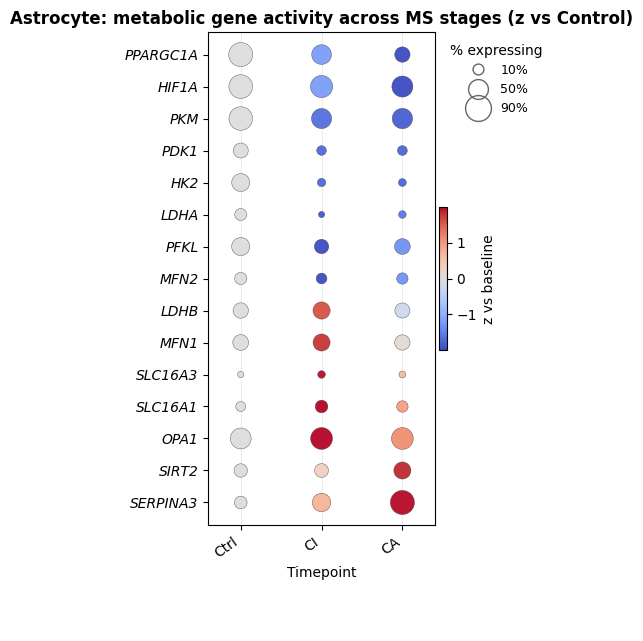

Saved ../data/zscore_results/OL_zscore_LermaMartin.csv


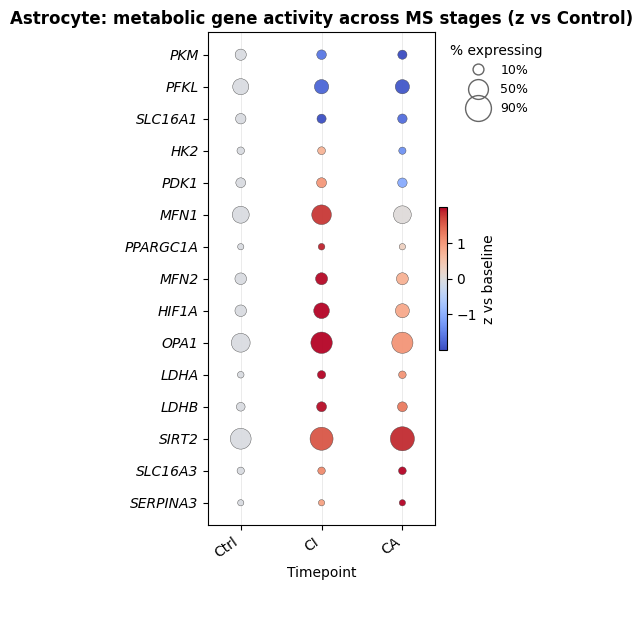

Saved ../data/zscore_results/MG_zscore_LermaMartin.csv


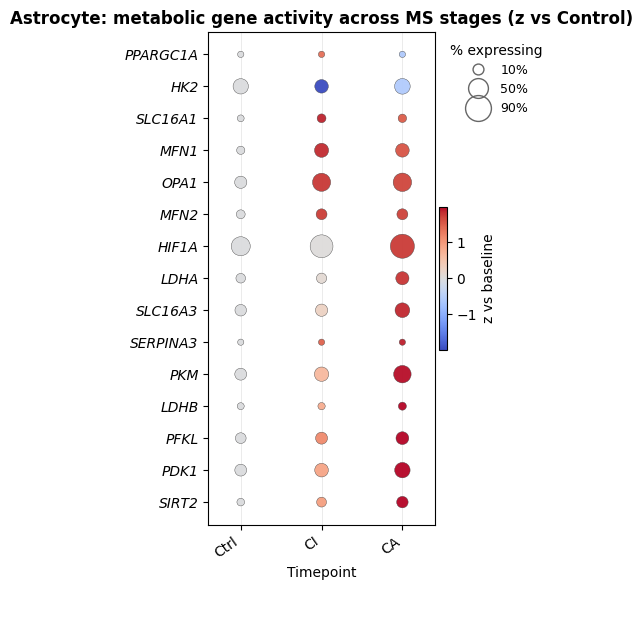

In [38]:
import os

outdir = "../data/zscore_results/"
dataset = 'LermaMartin'
os.makedirs(outdir, exist_ok=True)

for cell in ['AS', 'OL', 'MG']:

    # 2) summarize within one cell type across stages
    tbl = summarize_by_time(
        adata, human_genes, celltype=cell,   # <-- set to your label in adata.obs
        time_col="lesion_type",                            # e.g. "Control","Chronic inactive","Acute/Chronic active"
        ct_col="celltype",                           # change if your column is different
        layer=None,                                  # or "raw"/your layer name
        detect_threshold=0.0,
        time_order=["Ctrl","CI","CA"]
    )
    
    # 3) add z-scores anchored at Control
    tblz = compute_zscores_vs_baseline(tbl, baseline_time="Ctrl")

    # ---- SAVE each table ----
    outfile = os.path.join(outdir, f"{cell.replace(' ','_')}_zscore_"+dataset+".csv")
    tblz.to_csv(outfile, index=False)
    print(f"Saved {outfile}")

    # 4) plot z vs baseline
    plot_dotplot_time(
        tblz,
        title="Astrocyte: metabolic gene activity across MS stages (z vs Control)",
        color_mode="z_vs_baseline",
        sort_genes="z",                 # rank genes by z in the chosen time
        sort_genes_time="CA"
    )

In [ ]:
# 1) pick genes (human symbols)
human_genes = [
    "HIF1A","HK2","LDHA","LDHB","MFN1","MFN2","OPA1","PDK1",
    "PFKL","PKM","PPARGC1A","SERPINA3","SIRT2","SLC16A1","SLC16A3"
]

# 2) summarize within one cell type across stages
tbl = summarize_by_time(
    adata, human_genes, celltype="MG",   # <-- set to your label in adata.obs
    time_col="lesion_type",                            # e.g. "Control","Chronic inactive","Acute/Chronic active"
    ct_col="celltype",                           # change if your column is different
    layer=None,                                  # or "raw"/your layer name
    detect_threshold=0.0,
    time_order=["Ctrl","CI","CA"]
)

# 3) add z-scores anchored at Control
tblz = compute_zscores_vs_baseline(tbl, baseline_time="Ctrl")

# 4) plot z vs baseline (red=high, blue=low)
plot_dotplot_time(
    tblz,
    title="Microglia: metabolic gene activity across MS stages (z vs Control)",
    color_mode="z_vs_baseline",
    sort_genes="z",                 # rank genes by z in the chosen time
    sort_genes_time="CA"
)